# 1D head diffusion

In [1]:
# Import modules and packages.
from matplotlib import pyplot
import numpy

%matplotlib inline

In [2]:
# Update default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Discretization

$$
\frac{T_i^{n+1} - T_i^n}{\Delta t} = c_E \alpha \frac{T_{i-1}^n - 2 T_i^n + T_{i+1}^n}{\Delta x^2} + c_I \alpha \frac{T_{i-1}^{n+1} - 2 T_i^{n+1} + T_{i+1}^{n+1}}{\Delta x^2}
$$


* Forward Euler (explicit): $C_E = 1$, $C_I = 0$
* Backward Euler (implicit): $C_E = 0$, $C_I = 1$
* Crank-Nicolson (semi-implicit): $C_E = \frac{1}{2}$, $C_I = \frac{1}{2}$

Matrix-vector representation:

$$
\begin{split}
    &\left( \mathbf{I} - c_I \alpha \Delta t \mathbf{L} \right) T^{n+1} = \left( \mathbf{I} + c_E \alpha \Delta t \mathbf{L} \right) T^n + b_\text{b.c.} \\
    &\qquad \quad \Rightarrow \quad \mathbf{A} T^{n+1} = b
\end{split}
$$

## Parameters and initial conditions

In [3]:
# Set parameters.
L = 1.0  # length of the 1D domain
nx = 21  # number of spatial points.
dx = L / (nx - 1)  # spatial grid spacing
x = numpy.linspace(0.0, L, num=nx)  # spatial locations

alpha = 1.22e-3  # coefficient of diffusion
T_left = 100.0  # Fix temperature at the left boundary
q_right = 0.0  # Fix gradient at the right boundary
N = nx - 2
# Set initial solution at interior points.
T0 = numpy.zeros(nx-2)

## Left-hand side operator

$$
\mathbf{A} = \mathbf{I} - c_I \alpha \Delta t \mathbf{L}
$$

where $\mathbf{I}$ is the identity operator and $\mathbf{L}$ is the 1D Laplacian operator.

### 1D Laplacian

$$
\nabla^2 T_i = \left. \frac{\partial^2 T}{\partial x^2} \right|_i = \frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2}
$$

$$
\mathbf{L} = \frac{1}{\Delta x^2}
\begin{bmatrix}
    -2 & 1 & & & \\
    1 & -2 & 1 & & (0) \\
    & \ddots & \ddots & \ddots & & \\
    (0) & & 1 & -2 & 1 \\
    & & & 1 & -1 \\
\end{bmatrix}
$$

In [4]:
def laplacian1d(N, dx):
    """Assemble the 1D Laplacian operator.
    
    Parameters
    ----------
    N : int
        Number of interior points (dimension of the square matrix).
    dx : float
        Spatial grid spacing.
        
    Returns
    -------
    numpy.ndarray
        The 1D Laplacian operator (as a 2D square matrix).
    
    """
    Lap = numpy.zeros(N)
    L1 = numpy.diag(1.0 * numpy.ones(N-1), k=-1)
    U = numpy.diag(1.0 * numpy.ones(N-1), k=1)
    D = numpy.diag(-2.0 * numpy.ones(N))
    D[-1, -1] = -1.0
    
    A = D + U + L1
    Lap = (1/dx**2)*A
    return Lap

In [5]:
def lhs_operator(N, alpha, dt, cI, dx):
    """Assemble the left-hand side operator.
    
    Parameters
    ----------
    N : int
        Number of interior points (dimension of the square matrix).
    alpha : float
        Coefficient of diffusion.
    dt : float
        Time-step size.
    cI : float
        Implicit coefficient of the scheme.
    dx : float
        Spatial grid spacing.
    
    Returns
    -------
    numpy.ndarray
        The left-hand side operator (as a 2D square matrix).

    """
    L2 = laplacian1d(N, dx)
    I = numpy.identity(N)
    A = I - (cI*alpha*dt*L2)

    return A

## Right-hand side vector

$$
b = \left( \mathbf{I} + c_E \alpha \Delta t \mathbf{L} \right) T^n + b_\text{b.c.}
$$

In [6]:
def rhs_vector(T, N, alpha, dt, cE, dx, T_left, q_right):
    """Assemble the right-hand side vector.
    
    Parameters
    ----------
    T : numpy.ndarray
        Solution at previous time step.
    N : int
        Number of interior points (lenght of the RHS vector).
    alpha : float
        Coefficient of diffusion.
    cE : float
        Explicit coefficient of the scheme.
    dx : float
        Spatial grid spacing.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
        
    Returns
    -------
    numpy.ndarray
        The RHS vector (as a 1D array).

    """
    I = numpy.identity(N)
    b_bc = numpy.zeros(N)
    sigma = alpha * dt / dx**2
    L = laplacian1d(N, dx)
#     b = numpy.dot(I + cE*alpha*dt*L, T) + b_bc
    b = (I + cE*alpha*dt*L) @ T + b_bc
    
    b[0] += sigma * T_left
    b[-1] += sigma * q_right * dx
    return b

## Create the solver...

... such that we can use different numerical schemes.

In [7]:
def solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Forward Euler'):
    """Solve the system over a given number of time steps.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        Initial temperature field (as a 1D array).
    nt : int
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Spatial grid spacing.
    alpha : float
        Coefficient of diffusion.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
    method : str, optional
        The numerical scheme to use;
        choices are 'Forward Euler', 'Backward Euler',
        and `Crank-Nicolson`; default is 'Forward Euler'.
    
    Returns
    -------
    numpy.ndarray
        Temperature after given number of time steps (as a 1D array).

    """
    # Create a dictionary that maps the method's name
    # to the explicit and implicit coefficients of the scheme.
    coeffs = {'Forward Euler': (1.0, 0.0),
              'Backward Euler': (0.0, 1.0),
              'Crank-Nicolson': (0.5, 0.5)}
    cE, cI = coeffs[method]  # store the coefficients

        
    T = T0.copy()
    N = len(T0)
    A = lhs_operator(N, alpha, dt, cI, dx)
    for n in range(nt):
        Tn = numpy.copy(T)
        b = rhs_vector(Tn, N, alpha, dt, cE, dx, T_left, q_right)
        T = numpy.linalg.solve(A, b)

    
    return T

In [8]:
# Set temporal parameters.
sigma = 0.5  # CFL-like number
dt = sigma* dx**2 / alpha  # time-step size
nt = 10  # number of time steps.
T_cn = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Crank-Nicolson')

In [9]:
def array_with_boundaries(T, T_left, q_right, dx):
    """Return an extended array with boundary values.
    
    Parameters
    ----------
    T : numpy.ndarray
        Solution at interior points.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
    dx : float
        Spatial grid spacing.
        
    Returns
    -------
    numpy.ndarray
        The extended solution (that includes boundary values).

    """
    T_right = T[-1] + q_right * dx
    T_ext = numpy.concatenate(([T_left], T, [T_right]))
    return T_ext

(0.0, 100.0)

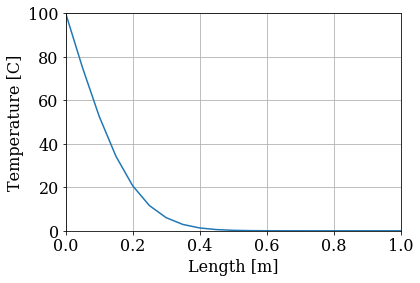

In [10]:
T_ext = array_with_boundaries(T_cn, T_left, q_right, dx)

pyplot.figure()
pyplot.xlabel('Length [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T_ext)
pyplot.xlim(0.0, 1.0)
pyplot.ylim(0.0, 100.0)


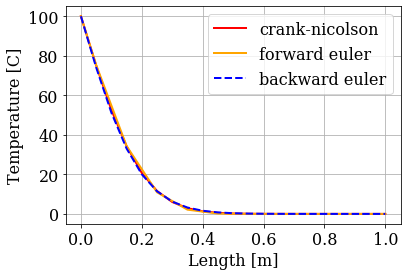

In [11]:
T_fe = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Forward Euler')
T_be = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Backward Euler')
T_fe = array_with_boundaries(T_fe, T_left, q_right, dx)
T_be = array_with_boundaries(T_be, T_left, q_right, dx)

pyplot.figure(figsize=(6.0,4.0))
pyplot.plot(x,T_ext,label='crank-nicolson',color='red',linestyle='solid',linewidth=2)
pyplot.plot(x,T_fe,label='forward euler',color='orange',linestyle='-',linewidth=2)
pyplot.plot(x,T_be,label='backward euler',color='blue',linestyle='--',linewidth=2)
pyplot.xlabel('Length [m]')
pyplot.ylabel('Temperature [C]')
pyplot.legend()
pyplot.grid()


## Analytical solution

$$
T \left( x, t \right) = 100 - \sum_{n=1}^\infty \frac{400}{(2n - 1) \pi} \sin \left( \frac{(2n - 1) \pi}{2L} x \right) \exp \left( -\alpha \left( \frac{(2n - 1) \pi}{2L} \right)^2 t \right)
$$

We can compute a truncated version of the analytical solution.

In [12]:
def analytical_temperature(x, t, alpha, L, N=100):
    """Compute a truncated exact solution.
    
    Parameters
    ----------
    x : numpy.ndarray
        The grid locations (as a 1D array of floats).
    t : float
        Time values.
    alpha : float
        Coefficient of diffusion.
    L : float
        Length of the domain.
    N : int, optional
        Number of terms to evaluate for the truncation solution;
        default: 100.
    
    Returns
    -------
    numpy.ndarray
        The truncated exact solution (as a 1D array).

    """
    T = 100.0 * numpy.ones_like(x)
    for n in range(1, N + 1):
        k = (2* n-1) * numpy.pi / (2.0*L)
        T -= (400/(2.0*L*k)*
              numpy.sin(k*x) * numpy.exp(-alpha*k**2*t))
    
    return T

In [13]:
T_exact = analytical_temperature(x,nt*dt,alpha,L,N=100)


(0.0, 100.0)

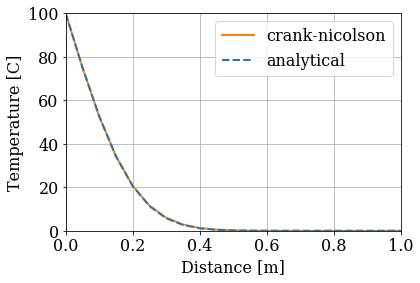

In [14]:
pyplot.figure(figsize=(6.0,4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x,T_ext, label='crank-nicolson',
            color='C1', linestyle='-',linewidth=2)
pyplot.plot(x, T_exact, label='analytical',
            color='C0',linestyle='--', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0,L)
pyplot.ylim(0.0,100.0)

## Temporal convergence analysis

In [15]:
def l2_error(u, u_exact):
    """
    Computes and returns the relative L2-norm
    of the difference between the numerical solution
    and the exact solution.
    
    Parameters
    ----------
    u : numpy.ndarray
        The numerical solution as an array of floats.
    u_exact : numpy.ndarray
        The exact solution as an array of floats.
    
    Returns
    -------
    error : float
        The relative L2-norm of the difference.
    """
    error = numpy.sqrt(numpy.sum((u - u_exact)**2) /
                       numpy.sum(u_exact**2))
    return error

In [18]:
# Perform temporal convergence analysis.
nx = 1001  # number of spatial points in the domain
dx = L / (nx - 1)  # spatial grid spacing
x = numpy.linspace(0.0, L, num=nx)  # spatial locations

# Time-step sizes for which the solution will be computed.
dt_vals = [1.0, 0.5, 0.25, 0.125]

# List to store the relative L2-norms
errors_cn = []  # for Crank-Nicolson
errors_bt = []  # for Backward Euler

# Compute the initial solution.
t0 = 1.0
T0 = analytical_temperature(x[1:-1], t0, alpha, L)
# Compute the final solution.
tf = 10.0
T_e = analytical_temperature(x[1:-1], tf, alpha, L)

for dt in dt_vals:
    nt = int((tf - t0) / dt)
    Tcn = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Crank-Nicolson')
#     Tcn = array_with_boundaries(Tcn, T_left, q_right, dx)
    errors_cn.append(l2_error(Tcn, T_e))
    Tbwe = solver(T0, nt, dt, dx, alpha, T_left, q_right,
                  method='Backward Euler')
#     Tbwe = array_with_boundaries(Tbwe, T_e)
    errors_bt.append(l2_error(Tbwe, T_e))
    

In [24]:
def loglog_plot(dt_vals, errors1, errors2, label1='none', label2='label2'):
    pyplot.figure(figsize=(6.0,6.0))
    pyplot.grid()
    pyplot.xlabel(r'$\Delta t$')
    pyplot.ylabel('Relative $L_2$-norm\nof the error')
    pyplot.loglog(dt_vals, errors1, label=label1, color='black',
                  linestyle='--',linewidth=2,marker='o')
    pyplot.loglog(dt_vals, errors2, label=label2, color='black',
                  linestyle='--', linewidth=2, marker='s')
    pyplot.legend()
    pyplot.axis('equal')

loglog_plot(dt_vals, errors_cn, errors_bt, label1='Crank-nicolson',
            label2='Backward Euler')

SyntaxError: invalid syntax (<ipython-input-24-ab865a9b7ccb>, line 1)

What's the order of convergence in time for Crank-Nicolson and for Backward Euler?

## Spatial convergence analysis

In [23]:
dt = 0.1  # time-step size
tf = 20.0  # final time
nt = int(tf / dt)  # number of time steps

# Spatial grid spacings for which the solution will be computed.
dx_vals = [0.1, 0.05, 0.025, 0.0125, 0.00625]

# List to store the relative L2-norm of the error.
errors = []

for dx in dx_vals:
    nx = int(L/dx + 1)
    x = numpy.linspace(0.0, L, num=nx)
    T0 = numpy.zeros(nx-2)
    Tcn = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Crank-Nicolson')
    T_e = analytical_temperature(x[1:-1], tf, alpha, L)
    errors.append(l2_error(Tcn, T_e))
    ###
    ### To do: compute the solution with Crank-Nicolson,
    ### compute the analytical solution,
    ### compute the relative L2-norm of the error.
    ###
    

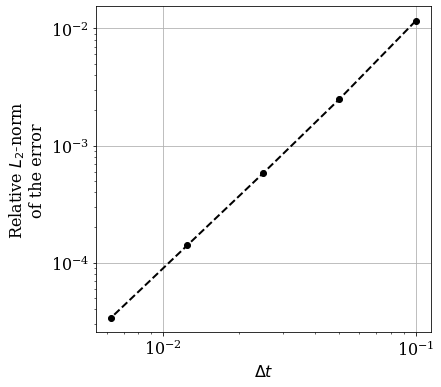

In [28]:
pyplot.figure(figsize=(6.0,6.0))
pyplot.grid()
pyplot.xlabel(r'$\Delta t$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.loglog(dx_vals, errors, label='Crank-nicolson', color='black',
              linestyle='--',linewidth=2,marker='o')


What's the order of convergence in space of the Crank-Nicolson method?

## Spatial convergence analysis at later time

In [29]:
dt = 0.1  # time-step size
tf = 1000.0 # final time (we want the solution way later in time)
nt = int(tf / dt)  # number of time steps

# Spatial grid spacings for which the solution will be computed.
dx_vals = [0.1, 0.05, 0.025, 0.0125, 0.00625]

# List to store the relative L2-norm of the error.
errors = []

for dx in dx_vals:
    nx = int(L/dx + 1)
    x = numpy.linspace(0.0, L, num=nx)
    T0 = numpy.zeros(nx-2)
    Tcn = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Crank-Nicolson')
    T_e = analytical_temperature(x[1:-1], tf, alpha, L)
    errors.append(l2_error(Tcn, T_e))   

    ###
    ### To do: compute the solution with Crank-Nicolson,
    ### compute the analytical solution,
    ### compute the relative L2-norm of the error.
    ###
    

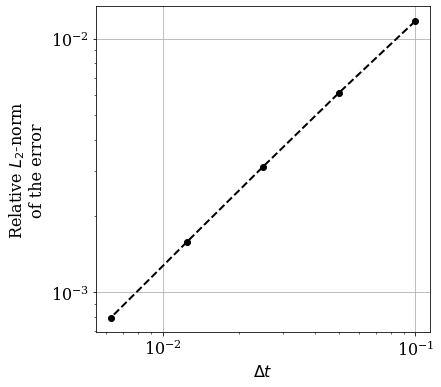

In [30]:
pyplot.figure(figsize=(6.0,6.0))
pyplot.grid()
pyplot.xlabel(r'$\Delta t$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.loglog(dx_vals, errors, label='Crank-nicolson', color='black',
              linestyle='--',linewidth=2,marker='o')

###
### To do: plot the errors versus the spatial grid spacing
### (using a log/log plot).
###


How is the spatial order of convergence affected?
And why?